In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.layers.core import Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import cv2
import pickle
import pandas as pd
from keras import applications
from sklearn.model_selection import train_test_split

############## Hyperparameters #############

learning_rate = 0.1
weight_decay = 0.0005
lr_decay = 1e-6
lr_drop = 20
maxepochs = 200

################ Optimizers ###############

optim = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

# optim = optimizers.Adam(lr=learning_rate*.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=lr_decay, amsgrad=False)

################# MNIST Dataset ##############

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

img_size = 64

def upsample(img):
    img = cv2.resize(img,(img_size,img_size),interpolation = cv2.INTER_AREA)
    return img

def upsampleData(img_size, data, filename):
    
    new_imgs = []
    new_img = []

    for i in range(round(len(data))):
        new_img = np.dstack((upsample(data[i]),upsample(data[i]),upsample(data[i])))
        new_imgs.append(new_img)
    
    new_imgs=np.array(new_imgs).reshape(-1,img_size,img_size,3)
    
    pickle_out = open(filename, "wb")             #Save bitstream to external file
    pickle.dump(new_imgs, pickle_out)
    pickle_out.close()
    
    return new_imgs

try:
    pickle_in = open("MNIST_x_train", "rb")          #If upsampled data already exists just load it
    x_train = pickle.load(pickle_in)

    pickle_in = open("MNIST_x_test", "rb")
    x_test = pickle.load(pickle_in)
    print('Upsampled MNIST dataset loaded')
    
except:
    print('Upsampled dataset not found, building new dataset')      #Otherwise create new data
    x_train = upsampleData(img_size, x_train, filename = 'MNIST_x_train' )
    x_test = upsampleData(img_size, x_test, filename = 'MNIST_x_test' )
    print('Upsampled MNIST dataset loaded')

batch_size = 10
num_classes = 10
x_shape = [img_size,img_size,3]
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Upsampled MNIST dataset loaded


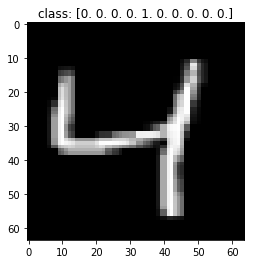

In [2]:
plt.figure()
plt.imshow(x_train[2])
plt.title('class: ' + str(y_train[2]))
plt.show()

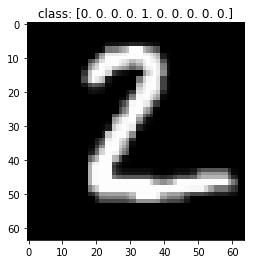

In [3]:
plt.figure()
plt.imshow(x_test[1])
plt.title('class: ' + str(y_train[2]))
plt.show()

In [4]:
datagen = ImageDataGenerator(
    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
    
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
def MNIST_model(weights_path=None):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))    
    
    if weights_path:
        model.load_weights(weights_path, by_name=True)
    
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

In [ ]:
MNIST_model = MNIST_model()
MNIST_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
MNIST_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
cnn = MNIST_model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                epochs=maxepochs,
                                validation_data=(x_test, y_test),callbacks=[reduce_lr], verbose=1, shuffle = True)